# **Tweet Predictor**

In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


# **Data Loading**

In [399]:
df_tweet_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_tweet_test = pd.read_csv('../input/nlp-getting-started/test.csv')

In [46]:
df_tweet_train.shape

(7613, 5)

The dataset consists of 7613 records with 5 distinct features.

In [47]:
df_tweet_test.shape

(3263, 4)

The dataset consists of 3263 records with 4 distinct features.

In [48]:
print(df_tweet_train.columns)
print(df_tweet_test.columns)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Index(['id', 'keyword', 'location', 'text'], dtype='object')


In [49]:
df_tweet_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


The features has 2 numeric values and 3 categoric values.

In [50]:
df_tweet_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


The features has 1 numeric values and 3 categoric values.

# **Data Cleaning**

In [51]:
print(round(((((df_tweet_train.isnull().sum())/(df_tweet_train.shape[0])).sort_values(ascending=False))*100),3))
print('\n')
print(round(((((df_tweet_test.isnull().sum())/(df_tweet_test.shape[0])).sort_values(ascending=False))*100),3))

location    33.272
keyword      0.801
target       0.000
text         0.000
id           0.000
dtype: float64


location    33.865
keyword      0.797
text         0.000
id           0.000
dtype: float64


Location and keywords have minor missing values in the training as well as the testing datasets, thus we need to handle these values. 

In [54]:
df_tweet_train['keyword'].mode()[0]

'fatalities'

In [55]:
df_tweet_train['location'] = df_tweet_train['location'].fillna(
                             df_tweet_train['location'].mode()[0])

df_tweet_test['location'] = df_tweet_test['location'].fillna(
                            df_tweet_test['location'].mode()[0])


In [56]:
df_tweet_train['keyword'] = df_tweet_train['keyword'].fillna(
                            df_tweet_train['keyword'].mode()[0])

df_tweet_test['keyword'] = df_tweet_test['keyword'].fillna(
                           df_tweet_test['keyword'].mode()[0])

In [57]:
print(round(((((df_tweet_train.isnull().sum())/(df_tweet_train.shape[0])).sort_values(ascending=False))*100),3))
print()
print(round(((((df_tweet_test.isnull().sum())/(df_tweet_test.shape[0])).sort_values(ascending=False))*100),3))

target      0.0
text        0.0
location    0.0
keyword     0.0
id          0.0
dtype: float64

text        0.0
location    0.0
keyword     0.0
id          0.0
dtype: float64


# **Data Visualization**

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

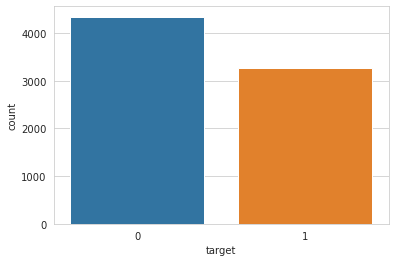

In [13]:
sns.countplot(df_tweet_train['target'])

The number of Fake tweets are more than Real tweets which are denoted as 0 and 1 respectively.

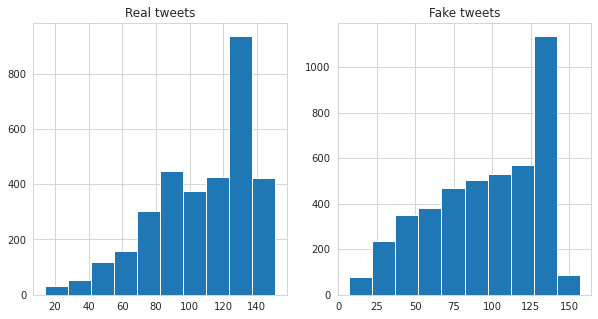

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

tlen=df_tweet_train[df_tweet_train['target']==1]['text'].str.len()
ax1.hist(tlen)
ax1.set_title('Real tweets')

tlen=df_tweet_train[df_tweet_train['target']==0]['text'].str.len()
ax2.hist(tlen)
ax2.set_title('Fake tweets')

plt.show()

Maximum length of tweets of Disastrous tweets and Non-Disastrous tweets lie between 120-150.

Text(0, 0.5, 'Number of Tweets')

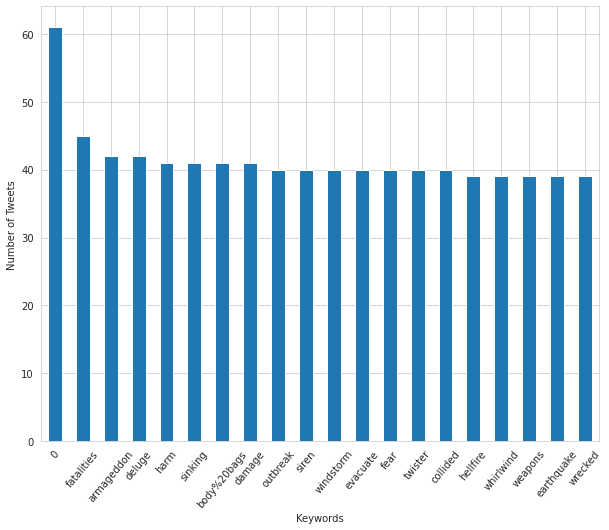

In [15]:
plt.figure(figsize=(10,8))
df_tweet_train['keyword'].value_counts()[:20].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Keywords")
plt.ylabel("Number of Tweets")

Fatalities is the most used keyword to indicate an accident within the tweets.

Text(0, 0.5, 'Number of Tweets')

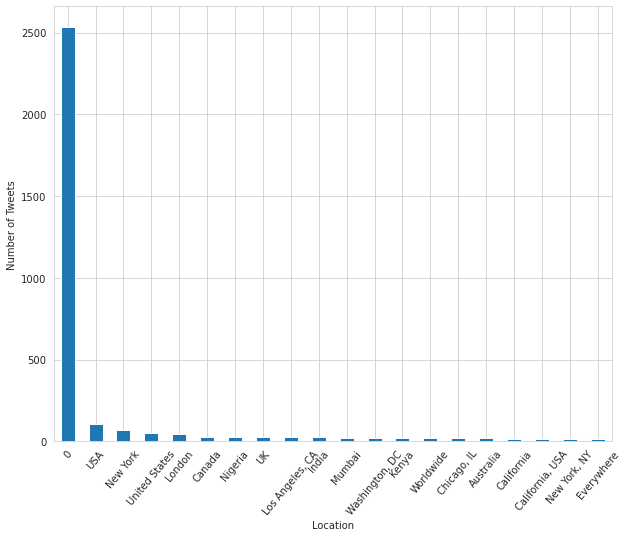

In [16]:
plt.figure(figsize=(10,8))
df_tweet_train['location'].value_counts()[:20].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Location")
plt.ylabel("Number of Tweets")

Maximum tweets have been tweeted from USA. 
We notice there are inconsistencies with respect to the location as some tweets are labelled with only the country, some along with the state and the rest with only the state. We will furthur look into this inconsistency

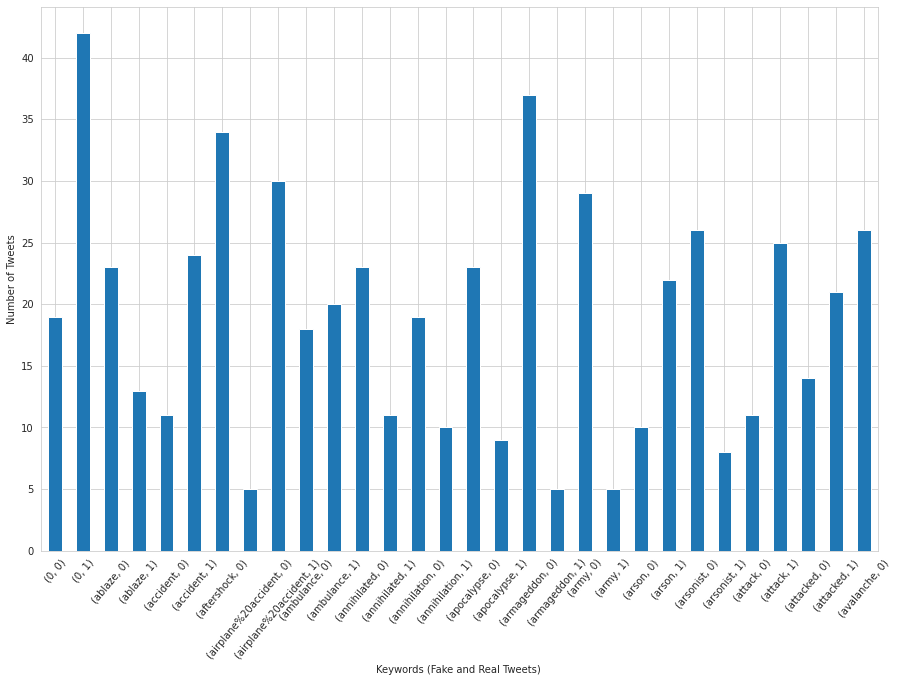

In [17]:
target = df_tweet_train.groupby(['keyword','target'])

plt.figure(figsize=(15,10))
target.count()['id'][:30].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Keywords (Fake and Real Tweets) ")
plt.ylabel("Number of Tweets")

plt.show()

Ignoring certain inconsistencies we can identify that accident, apocalypse and armagedon are the three trending words posted in a tweet to indicate a fatality. Whereas aftershock, army, annihilation are less trending words used. 

In [119]:
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud

In [245]:
def word(text):
    
    comment_words = ' '
    stopwords = list(STOP_WORDS) 
    
    for val in text: 

         
        val = str(val)   
        tokens = val.split() 

        
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 500, height = 400, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

                            
    plt.figure(figsize = (12, 12), facecolor = None ) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

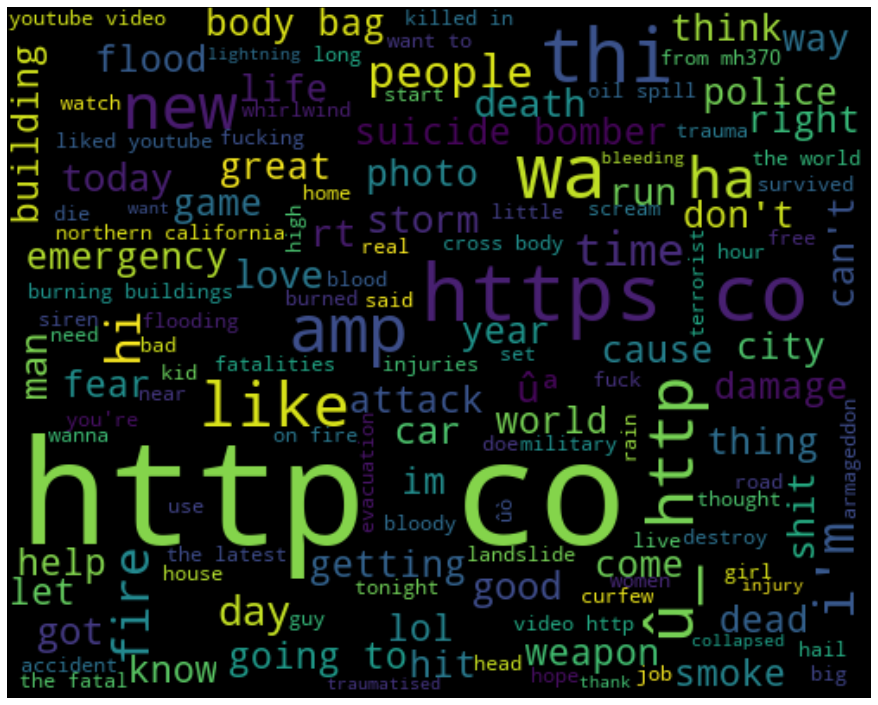

In [400]:
text = df_tweet_train.text.values
word(text)

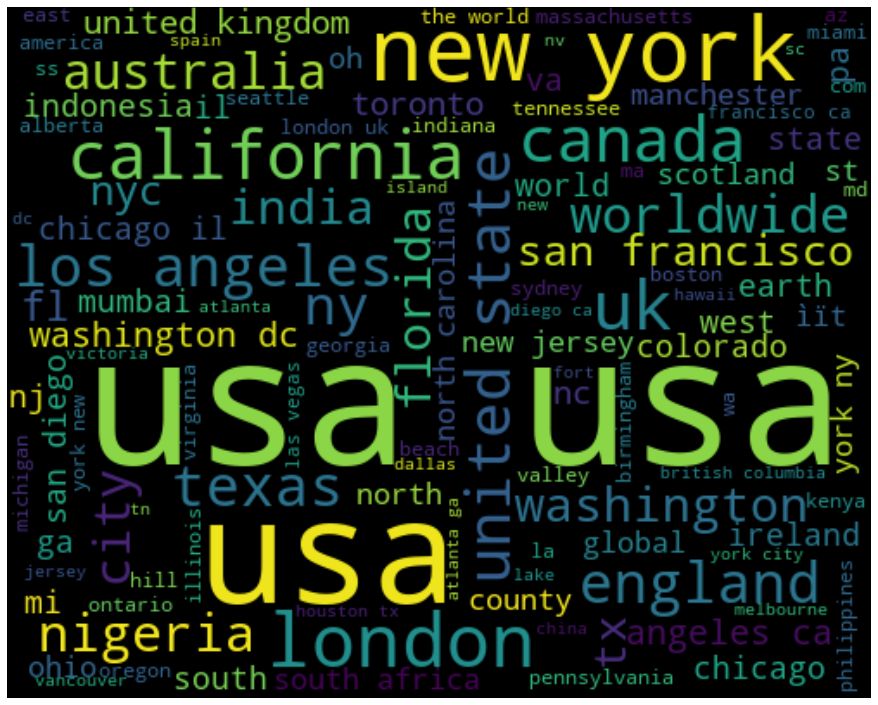

In [122]:
text = df_tweet_train.location.values
word(text)

# **Feature Engineering**

We notice that our "Text" is very dirty. Thus it is necessary that we filter out all the unwanted signs, symbols, hyperlinks, hastags, etc.

In [123]:
import nltk, re
data = [df_tweet_train, df_tweet_test]

In [239]:
def html_tag(value):
    
    result = re.sub(r"<[^>]+#>", "", value)
    return result

def hyperlink(value):
    
    result = re.sub(r"https?://\S+|www\.\S+", "", value)
    return result

def hashtag(value):
    
    result = re.sub(r"#", "", value)
    return result

def emoticon(value):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',value)

In [240]:
for dataset in data:
    
    dataset['text'] = dataset['text'].apply(html_tag)
    dataset['text'] = dataset['text'].apply(hyperlink)
    dataset['text'] = dataset['text'].apply(hashtag)
    dataset['text'] = dataset['text'].apply(emoticon)

During the analysis we notice many inconsitencies in the loction feature. We now try to extract the correct loctation of each tweet with the help of pycountry library.

In [225]:
import pycountry

def findcon1(text):
        
    for country in pycountry.countries:
        if country.name in text:   
            a = country.name
            return a
        else:
            try:
                a = pycountry.countries.search_fuzzy(text.split()[-1])[0].name
                return a
            
            except:
                return text

In [230]:
for dataset in data:
    
    dataset['nlocation'] = dataset['location'].apply(lambda x : findcon1(x))
    

Text(0, 0.5, 'Number of Tweets')

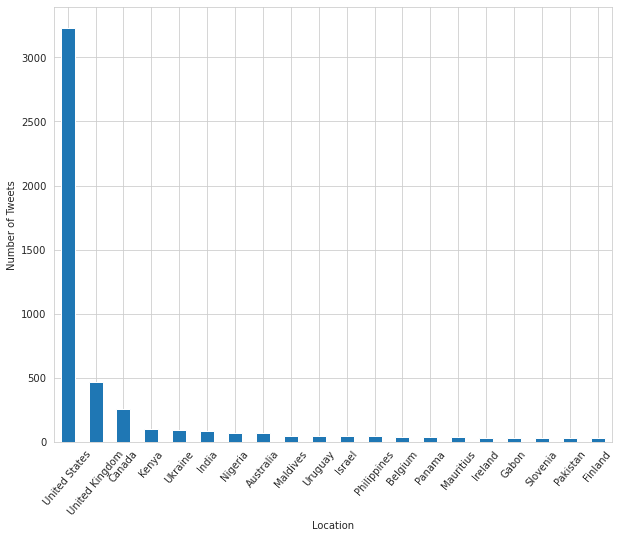

In [242]:
plt.figure(figsize=(10,8))
df_tweet_train['nlocation'].value_counts()[:20].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Location")
plt.ylabel("Number of Tweets")

As compared to the previous inconistent locaton output, we get a better view so as to which countries have the highest number of tweets. The highest number of tweets belong to The United States.

# **Data Modeling**

In [247]:
df = df_tweet_train[['target','text']]

In [248]:
from sklearn.model_selection import train_test_split
X = df['text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Machine Learning**

* Naive Bayes Classifier

In [250]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import confusion_matrix

pipe1 = Pipeline([('vectorize', CountVectorizer()),('tfidf', TfidfTransformer()),('classifier', MultinomialNB())])

pipe1.fit(X_train, y_train)

prediction1 = pipe1.predict(X_test)

accuracy1 = round((pipe1.score(X_test, y_test)*100),0)
print('Accuracy: ',accuracy1,'%')
print()
print('Confusion Matrix: \n',confusion_matrix(y_test,prediction1))


Accuracy:  80.0 %

Confusion Matrix: 
 [[803  71]
 [235 414]]


* Linear Support Vector Machine

In [251]:
from sklearn.linear_model import SGDClassifier

pipe2 = Pipeline([('vectorize', CountVectorizer()),('tfidf', TfidfTransformer()),('classifier', SGDClassifier())])

pipe2.fit(X_train, y_train)

prediction2 = pipe2.predict(X_test)

accuracy2 = round((pipe2.score(X_test, y_test)*100),0)
print('Accuracy: ',accuracy2,'%')
print()
print('Confusion Matrix: \n',confusion_matrix(y_test, prediction2))

Accuracy:  81.0 %

Confusion Matrix: 
 [[747 127]
 [166 483]]


* Support Vector Machine

In [252]:
from sklearn.svm import SVC

pipe3 = Pipeline([('vectorize', CountVectorizer()),('tfidf', TfidfTransformer()),('classifier', SVC())])

pipe3.fit(X_train, y_train)

prediction3 = pipe3.predict(X_test)

accuracy3 = round((pipe3.score(X_test, y_test)*100),0)
print('Accuracy: ',accuracy3,'%')
print()
print('Confusion Matrix: \n',confusion_matrix(y_test, prediction3))

Accuracy:  81.0 %

Confusion Matrix: 
 [[788  86]
 [204 445]]


# **SpaCy**

In [253]:
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [254]:
stopwords = list(STOP_WORDS)
punctuations = string.punctuation
parser = English()

In [255]:
def tokenizer(sentence):
    tokens = parser(sentence)
    tokens = [ word.lemma_.lower() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ]
    tokens = [ word for word in tokens if word not in stopwords and word not in punctuations ]
    return tokens

In [256]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin 
from sklearn.svm import LinearSVC

In [257]:
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

 
    def clean_text(text):     
        return text.strip().lower()

* Count Vectorizer along with Support Vector Classifier

In [258]:
vectorizer = CountVectorizer(tokenizer = tokenizer, ngram_range=(1,1)) 
classifier = SVC()

In [259]:
pipe4 = Pipeline([('cleaner', predictors()),('vectorizer', vectorizer),('classifier', classifier)])

pipe4.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f3ddbcf8610>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenizer at 0x7f3ddd090320>,
                                 vocabulary=None)),
                ('classifier',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,


In [260]:
prediction4 = pipe4.predict(X_test)

accuracy4 = round((pipe4.score(X_test, y_test)*100),0)
print('Accuracy: ',accuracy4,'%')
print()
print('Confusion Matrix: \n',confusion_matrix(y_test,prediction4))

Accuracy:  80.0 %

Confusion Matrix: 
 [[794  80]
 [219 430]]


* TF-IDF Vectorizer along with Support Vector Classifier

In [261]:
tfvectorizer = TfidfVectorizer(tokenizer = tokenizer)

In [262]:
pipe5 = Pipeline([('cleaner', predictors()),('vectorizer', tfvectorizer),('classifier', classifier)])

pipe5.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f3ddc9bc910>),
                ('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_wor...
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenizer at 0x7f3ddd090320>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     

In [263]:
prediction5 = pipe4.predict(X_test)

accuracy5 = round((pipe5.score(X_test, y_test)*100),0)
print('Accuracy: ',accuracy5,'%')
print()
print('Confusion Matrix: \n',confusion_matrix(y_test,prediction5))

Accuracy:  80.0 %

Confusion Matrix: 
 [[866   8]
 [640   9]]


# **Neural Network**

In [264]:
import tensorflow as tf

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [330]:
sentences = df['text'].values
y = df['target'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.20, random_state=42)

* Basic Neural Model

In [331]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

In [332]:
model1 = Sequential()
model1.add(layers.Dense(32, input_dim=X_train.shape[1], activation='relu'))
model1.add(layers.Dense(64,activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model1.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 32)                475648    
_________________________________________________________________
dense_46 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 65        
Total params: 477,825
Trainable params: 477,825
Non-trainable params: 0
_________________________________________________________________


In [333]:
history = model1.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

In [334]:
loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)

accuracy6 = round((accuracy*100),0)
print('Accuracy: ',accuracy6,'%')

Accuracy:  78.0 %


* Bag Of Words (BOW)

In [340]:
vocab = {}  
word_encoding = 1
def bow(sentence):
    
    text = parser(sentence)
    text = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in text ]
    text = [ word for word in text if word not in stopwords and word not in punctuations ]
         
    global word_encoding
    words = text 
    bag = {}  

    for word in words:
        
        if word in vocab:
            encoding = vocab[word]  
        else:
            vocab[word] = word_encoding
            encoding = word_encoding
            word_encoding += 1
    
        if encoding in bag:
            bag[encoding] += 1
        else:
            bag[encoding] = 1
  
    return bag

In [371]:
vectorizer = TfidfVectorizer(tokenizer = bow)
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [372]:
model2 = Sequential()
model2.add(layers.Dense(32, input_dim=X_train.shape[1], activation='relu'))
model2.add(layers.Dense(64,activation='relu'))
model2.add(layers.Dense(128,activation='relu'))
model2.add(layers.Dense(256,activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model2.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 32)                489824    
_________________________________________________________________
dense_75 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_76 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_77 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 257       
Total params: 533,537
Trainable params: 533,537
Non-trainable params: 0
_________________________________________________________________


In [373]:
history = model2.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

In [374]:
loss, accuracy = model2.evaluate(X_test, y_test, verbose=False)

accuracy7 = round((accuracy*100),0)
print('Accuracy: ',accuracy7,'%')

Accuracy:  76.0 %


* Word Embedding  

In [375]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

In [376]:
vsize = len(tokenizer.word_index) + 1
edim = 50
maxlen = 100

In [385]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [394]:
model3 = Sequential()
model3.add(layers.Embedding(input_dim=vsize,output_dim=edim,input_length=maxlen))
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

model3.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 50)           787900    
_________________________________________________________________
flatten_8 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_92 (Dense)             (None, 256)               1280256   
_________________________________________________________________
dense_93 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_94 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_95 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_96 (Dense)             (None, 1)               

In [395]:
history = model3.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=32)


/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [396]:
loss, accuracy = model3.evaluate(X_test, y_test, verbose=False)

accuracy8 = round((accuracy*100),0)
print('Accuracy: ',accuracy8,'%')

Accuracy:  77.0 %


* Long-Short Term Memory (LSTM)

In [298]:
model4 = Sequential()
model4.add(layers.Embedding(input_dim=vsize,output_dim=edim,input_length=maxlen))
model4.add(layers.LSTM(50))
model4.add(layers.Dense(10, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           787900    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 808,621
Trainable params: 808,621
Non-trainable params: 0
_________________________________________________________________


In [299]:
history = model4.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [305]:
loss, accuracy = model4.evaluate(X_test, y_test, verbose=False)

accuracy9 = round((accuracy*100),0)
print('Accuracy: ',accuracy9,'%')

Accuracy:  57.0 %


* Neural Network with Pooling layers

In [301]:
model5 = Sequential()
model5.add(layers.Embedding(input_dim=vsize, output_dim=edim,input_length=maxlen))
model5.add(layers.GlobalMaxPooling1D())
model5.add(layers.Dense(10, activation='relu'))
model5.add(layers.Dense(1, activation='sigmoid'))

model5.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
model5.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           787900    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 11        
Total params: 788,421
Trainable params: 788,421
Non-trainable params: 0
_________________________________________________________________


In [302]:
history = model5.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)


In [304]:
loss, accuracy = model5.evaluate(X_test, y_test, verbose=False)

accuracy10 = round((accuracy*100),0)
print('Accuracy: ',accuracy10,'%')

Accuracy:  77.0 %


# **Conclusion**

In [397]:
data = [['Naive Bayes Classifier',accuracy1],
       ['Linear Support Vector Machine',accuracy2],
       ['Support Vector Machine',accuracy3],
       ['Count Vectorizer along with Support Vector Classifier',accuracy4],
       ['TF-IDF Vectorizer along with Support Vector Classifier',accuracy5],
       ['Basic Neural Model',accuracy6],
       ['Bag Of Words (BOW)',accuracy7],
       ['Word Embedding',accuracy8],
       ['Long-Short Term Memory (LSTM)',accuracy9],
       ['Neural Network with Pooling layers',accuracy10]]

final = pd.DataFrame(data,columns=['Algorithm','Precision'],index=[1,2,3,4,5,6,7,8,9,10])


In [398]:
print("The results of Data Modeling are as follows:\n ")
print(final)

The results of Data Modeling are as follows:
 
                                            Algorithm  Precision
1                              Naive Bayes Classifier       80.0
2                       Linear Support Vector Machine       81.0
3                              Support Vector Machine       81.0
4   Count Vectorizer along with Support Vector Cla...       80.0
5   TF-IDF Vectorizer along with Support Vector Cl...       80.0
6                                  Basic Neural Model       78.0
7                                  Bag Of Words (BOW)       76.0
8                                      Word Embedding       77.0
9                       Long-Short Term Memory (LSTM)       57.0
10                 Neural Network with Pooling layers       77.0


# **References**
1. SapCy  
https://github.com/Jcharis/Natural-Language-Processing-Tutorials/blob/master/Text%20Classification%20With%20Machine%20Learning,SpaCy,Sklearn(Sentiment%20Analysis)/Text%20Classification%20&%20Sentiment%20Analysis%20with%20SpaCy,Sklearn.ipynb
2. Neural Network  
https://www.kaggle.com/sanikamal/text-classification-with-python-and-keras
3. Neural Network (BOW) https://colab.research.google.com/drive/1ysEKrw_LE2jMndo1snrZUh5w87LQsCxk#forceEdit=true&sandboxMode=true&scrollTo=Fo3WY-e86zX2